<a href="https://colab.research.google.com/github/maraudxrxs/projects/blob/main/Database_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)Jim Bergdahl, Erik Wirdefeldt, Axel Rydja, Cecilia Parman

https://www.youtube.com/watch?v=B8SqKb3ttU0

If there is anything that is missing or should be added for grade A, we are happy to fix that. For example, the criteria "model and structure data according to actual constraints" is a bit vague.

# Reflection

What are the functions of a database management system? In simple terms, they are meant to be an efficient way to store and retrieve data. In our case, the data manipulation part is implemented by allowing users to insert new songs, update existing song information, delete songs, and query for specific rankings or genres. Using the pickle module, which serializes and deserializes objects, we created our data storage system.

Database management systems often ensure that *only* authorized users can access or modify the database. We did not implement such a feature, simply because there is no need to, considering the open-source nature of our data. However, if this was sensitive data, for example if we scraped it ourself and created a truly unique database, then it could be worthwhile to create a feature like that. One way of doing so would be to require users insert a username and password and then, using the hashlib-package in python, check against a list of authorized users.

Why use pickle? Our database relies on CSV files for importing and exporting once, which are readable and easy to import/export. Our songList contains a mix of years and custom (complex) Song objects, and without pickle we would have to manually covert each Song object attribute to a more basic structure (for example, a JSON or alike). Pickle serializes the entire song list with minimal effort and we store it in a text file for retrieval for another session. All in all, the automatic preservation, ease of use and compact binary format with pickle fit our needs perfectly.

Other points we've considered:
* Our "update" method allows for loading the latest data, which can be useful in real-time applications. This is one benefit of using NoSQL.


# Reflecting on our choice of Different Database Models

When we started this project, we knew we would have a quite a bit of data: the top 100 songs from over 60 years means 6000 songs, featuring 11 attributes each. For the sake of familiarity, and because we knew the database would be decently large and perhaps subject to change, we chose to develop a NoSQL database for our project. This comes with some advantages. First of all, the schema is flexible, meaning it is easier to change if we, for example, want to add a new row for the artists birth year. Another advantage is being able to manage both structured and unstructured data easier. In our case, structured data can be the song release date year, while unstructured data is often more like the lyrics in our songs.

Another advantage is the scalability. If this song database was to expand, then it would be far cheaper to scale horizontally than vertically

A final advantage of our NoSQL approach is the familiarity - for a simple project like this there is no point in using SQL when most of the pros of using a relational database would not be beneficial to us.

However, a relational database using SQL could also make sense for our project. We have structured data that, in all fairness, won't change much, so the advantages of flexibility are not too big. Relational databases work well for data such as ours. Complex relationships (using foreign keys) would also be an interesting addition, and more complex querying could lead to more intricate data retrieval. For example, we could get a list of songs, allong with their corresponding albums and artists, using joins. Constraints - such as unique primary keys for each table (e.g. SongID), or foreign keys for linking artistID to Song, or using constraints such as limiting rankings to a specific range - would all be fun to mess around with, but are ultimately not beneficial to our small scale project.

Also, using a declarative method like SQL could mean not having to load the entire dataset into memory, when querying data points. Using our current approach, the imperative pickle, we first need to deserialize.

All in all, we are happy about our choice of a NoSQL approach. We don't really need advanced querying, a high degree of data integrity or complex relationships. Furthermore, we have learned many of the techniques that make SQL unique (primary/foreign keys, constraints, etc.) in the Lab-part of the course - so using Python here has brought us knowledge of both NoSQL and SQL databases.

Sources we've used during the course:
* https://www.digitalocean.com/community/conceptual-articles/an-introduction-to-document-oriented-databases (and other articles)
* https://en.wikipedia.org/wiki/Relational_database#Primary_key
* https://www.mongodb.com/resources/basics/databases/nosql-explained

# Please run the code below first, to initialize the database:

In [ ]:
import pickle
import csv
import string
import requests

#All of the below are for showing Album images
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPImage, display, clear_output
import matplotlib.pyplot as plt

class Database():
    def __init__(self):
        self.fileName = "songData.txt"
        self.update()
        self.len = len(self.songList)

    def __store(self, data):
        with open(self.fileName, "wb") as file:
            pickle.dump(data, file) #Pickle-usage. Serialization
            file.close()

    def __get(self):
        try:
            with open(self.fileName, "rb") as file:
                data = pickle.load(file) #Pickle - deserialization
                file.close()
            return data
        except:
            return []

    def getSong(self, id, year): #Finds the song with the wanted rank (ID)
        for i in self.songList:
            if int(i[0]) == year:
                return i[id]
        return

    def getYear(self, year): #Returns the songs in the specified year
        for i in self.songList:
            if int(i[0]) == year:
                return i[1:]
        return

    def getCSV(self, name): #Downloads the CSV file locally
        name = name + ".csv"
        with open(name, "w", encoding = "utf-8") as file:
            dictWriter = csv.DictWriter(file, fieldnames =
            ["album", "albumURL", "artist", "featuredArtist", "lyrics", "media", "rank", "releaseDate", "songTitle", "songURL", "writers", "year"])
            dictWriter.writeheader()
            for year in self.songList:
                for song in year[1:]:
                    dict = song.getDict()
                    dictWriter.writerow(dict)
            file.close()

    def importCSV(self, name): #Imports the local CSV file
        csv.field_size_limit(10000000)
        with open(name, "r", encoding="utf-8") as CSVfile:
            songs = csv.reader(CSVfile)
            next(songs)
            for song in songs:
                self.storeSong(song)

            CSVfile.close()

        for songYear in self.songList:
            self.sortYear(songYear[0])

    def storeSong(self, attr): #Storing a song
        songYear = attr[11].strip("0").strip(".")
        for year in self.songList:
            if year[0] == songYear:
                year.append(Song(attr))
                return
        self.songList.append([songYear, Song(attr)])

    def save(self): #Saving the database
        self.__store(self.songList)

    def update(self): #Updating (or loading) the database
        self.songList = self.__get()

    def sortYear(self, year): #Sorts all songs in one specific year by title, alphabetically
        i = 0
        for songYear in self.songList:
            if year == songYear[0]:
                self.songList[i][1:] = sorted(songYear[1:], key=lambda song: song.songTitle)
            i += 1

    def findSong(self, targetSong): #Targetsong is the song we seek, and want to return
        for songYear in self.songList:
            song = self.binarySearch(targetSong, songYear)
            if song != -1:
                return songYear[song] #Songyear is a year, e.g. 2015.
        return

    def binarySearch(self, targetSong, songYear): #Binary search function
        left = 0
        right = len(songYear) - 1

        while left <= right:
            mid = (left + right) // 2
            songTitle = songYear[mid].songTitle

            if songTitle == targetSong:
                return mid

            elif songTitle < targetSong:
                left = mid + 1

            else:
                right = mid - 1

        return -1

    def importGitHub(self, urlGitHub, localName): #Imports the database hosted on github
      fileObject = requests.get(urlGitHub)
      with open(localName, "wb") as file:
        file.write(fileObject.content)
      self.importCSV(localName)

class Song():
    def __init__(self, attr):
        self.album = attr[0]
        self.albumURL = attr[1]
        self.artist = attr[2]
        self.featuredArtist = attr[3]
        self.lyrics = attr[4]
        self.media = attr[5]
        self.rank = attr[6]
        self.releaseDate = attr[7]
        self.songTitle = attr[8]
        self.songURL = attr[9]
        self.writers = attr[10]
        self.year = attr[11]

    #Optional:
    def __str__(self):
              return (f"Song Title: {self.songTitle}\n"
                f"Artist: {self.artist}\n"
                f"Featured Artist(s): {self.featuredArtist}\n"
                f"Album: {self.album} + {self.albumURL}\n"
                f"Release Date: {self.releaseDate}\n"
                f"Rank: {self.rank}\n"
                f"Lyrics (first 100 chars): {self.lyrics[:100]}...\n"
                f"Album URL: {self.albumURL}\n"
                f"Song URL: {self.songURL}\n"
                f"Writers: {self.writers}\n")


    def get_first_writer_image(self): #Looks for the first writer listed in the song credits, which is often the main writer
      start_index = self.writers.find("https://") #A bit of a rough solution, but it works
      if start_index != -1: #if not false (no writers, which happens)
          end_index = self.writers.find(" ", start_index)
          if end_index == -1:
              end_index = len(self.writers)
          return self.writers[start_index:end_index-2]  #return the url
      return None

    def getDict(self):
        return vars(self)

def display_song_info(song):
    #Massively useful: https://matplotlib.org/stable/tutorials/pyplot.html

    #get image of writer
    image_url = song.get_first_writer_image()

    #set up a figure, and hide the ugly axis
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('off')

    #lyrics, first 200 characters
    lyrics = song.lyrics[:200]

    #top text
    title = f"Song Title: {song.songTitle}\nArtist: {song.artist}\nAlbum: {song.album}\nRelease Date: {song.releaseDate}\nLyrics:\n{lyrics}..."

    if image_url:#Here, we fetch an image from the URL
        response = requests.get(image_url) #using the requests module
        img = Image.open(BytesIO(response.content)) #BytesIO is needed to handle binary data: https://docs.python.org/3/library/io.html
        ax.imshow(img.resize((500, 500)))

        ax.set_title(title, fontsize=14, pad=20)


    else: #if the url is not valid!
        ax.text(0.5, 0.5, title, fontsize=14, ha='center', va='center') #only text!

    plt.show(block=False)  # Change to non-blocking
    plt.close(fig)  # Close the figure immediately

def countUniqueWordsRatio(song): #Example usage 1: Provides a unique words ratio for a song
    lyrics = song.lyrics.translate(str.maketrans("", "", string.punctuation)).strip()

    lyrics_lower = lyrics.lower()

    if lyrics_lower in {"instrumental", "[instrumental]", "(instrumental)"}:
        return None

    words = lyrics_lower.split()

    if len(words) == 0:
        return None

    unique_words = set(words)

    return len(unique_words) / len(words)


def averageUniqueWordRatioForYear(year, database): #Example usage 2: A unique words ratio, for a specified year
    songs = database.getYear(year)

    if not songs:
        return 0

    total_ratio = 0
    valid_song_count = 0

    for song in songs:
        ratio = countUniqueWordsRatio(song)
        if ratio is not None:
            total_ratio += ratio
            valid_song_count += 1

    if valid_song_count == 0:
        return 0

    return total_ratio / valid_song_count


#Finally, we create the database
Db = Database()

# The code below runs the menu:

Q: Why separate the code blocks?

A: Because we do not want to re-initialize the database every time we want to access the menu. That only wastes time.


---Menu options---
Input "1" for loading and serializing all_songs_data.csv. To be run once initially.
Input "2" to *select* song via binary search given song title.
Input "3" to *select* song via a given year and id.
Input "4" for unique words ratio for given *selected* song.
Input "5" for unique words ratio for given year.
Input "6" to sort currently loaded database given a year.
Input "7" to update the database.
Input "8" to save the database
Input "9" to create and store a song
Input "10" to to get/export Database to CSV
Input "11" to exit program
Your input: 2
Input the song's title: wasdy


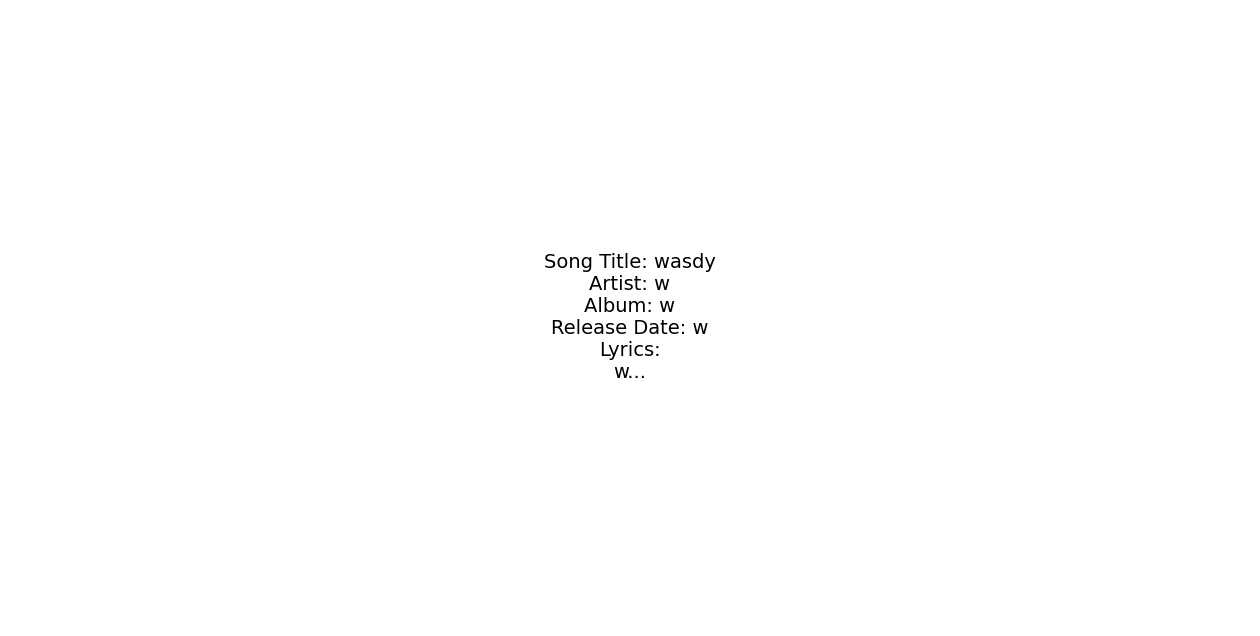

Song Title: wasdy
Artist: w
Featured Artist(s): w
Album: w + w
Release Date: w
Rank: w
Lyrics (first 100 chars): w...
Album URL: w
Song URL: 1
Writers: 1


---Menu options---
Input "1" for loading and serializing all_songs_data.csv. To be run once initially.
Input "2" to *select* song via binary search given song title.
Input "3" to *select* song via a given year and id.
Input "4" for unique words ratio for given *selected* song.
Input "5" for unique words ratio for given year.
Input "6" to sort currently loaded database given a year.
Input "7" to update the database.
Input "8" to save the database
Input "9" to create and store a song
Input "10" to to get/export Database to CSV
Input "11" to exit program
Your input: 11


In [ ]:
def menuOption():
    print()
    print("---Menu options---")
    print("""Input "1" for loading and serializing all_songs_data.csv. To be run once initially.""")
    print("""Input "2" to *select* song via binary search given song title.""")
    print("""Input "3" to *select* song via a given year and id.""")
    print("""Input "4" for unique words ratio for given *selected* song.""")
    print("""Input "5" for unique words ratio for given year.""")
    print("""Input "6" to sort currently loaded database given a year.""")
    print("""Input "7" to update the database.""")
    print("""Input "8" to save the database""")
    print("""Input "9" to create and store a song""")
    print("""Input "10" to to get/export Database to CSV""")

    print("""Input "11" to exit program""")

    # takes input
    return input("Your input: ")

def main(): #These are all the menu options, and what they do

    # initialize selected song to None
    givenSong = None

    while True:
        # prints all menu options
        option = menuOption()

        # option 1
        if option == "1":
            # Imports csv file from github and saves it locally
            Db.importGitHub("https://raw.githubusercontent.com/jimb21/songs/refs/heads/main/all_songs_data.csv", "importedCSV.csv") #Imports the CSV file from Jim's github. Also possible to upload, if necessary (SSH key needed)
            Db.save()
            print("initialization completed")


        if option == "2":
            song_title = input("Input the song's title: ")
            try:
                givenSong = Db.findSong(song_title)
                #print(f"Following song selected: {givenSong.songTitle}")

                # prints all the info
                display_song_info(givenSong)
                print(givenSong)
            except:
                print("Could not find song")

        # option 3
        if option == "3":
            try:
                year, id = input("Input the song's year and id [Year] [ID]: ").split()
                year = int(year)
                id = int(id)
                givenSong = Db.getSong(id, year)
                display_song_info(givenSong)

            except:
                print("Could not find song")


        if option == "4":
            if givenSong != 0:
                print(f"The song {givenSong.songTitle} has a ratio of unique words to total words of {countUniqueWordsRatio(givenSong)}")
            else:
                print("No song is currently selected")

        # option 5
        if option == "5":
            try:
                year = input("Input the song's year: ")
                year = int(year)
                print(f"The year {year} had an average ratio of unique words to total words of {averageUniqueWordRatioForYear(year, Db)}")
            except:
                print("Something went wrong. Not a number as input or database not loaded?")

        # option 6
        if option == "6":
            try:
                year = input("Input the song's year: ")
                year = int(year)
                Db.sortYear(year)
                print(f"All songs from {year} sorted")
            except:
                print("Something went wrong. Database not loaded?")


        if option == "7":
            Db.update()
            print("Updated the database")

        # option 8
        if option == "8":
            Db.save()
            print("Saved the database")

        # option 9
        if option == "9":
            attributes = []

            attributes.append(input("Enter the album name: "))
            attributes.append(input("Enter the album URL: "))
            attributes.append(input("Enter the artist name: "))
            attributes.append(input("Enter the featured artist (or leave blank): "))
            attributes.append(input("Enter the lyrics: "))
            attributes.append(input("Enter the media type: "))
            attributes.append(input("Enter the rank: "))
            attributes.append(input("Enter the release date: "))
            attributes.append(input("Enter the song title: "))
            attributes.append(input("Enter the song URL: "))
            attributes.append(input("Enter the writers: "))
            attributes.append(input("Enter the year: "))


            # try:
            Db.storeSong(attributes)
            Db.sortYear(int(attributes[11]))
            Db.save()
            print("Successfully added the song to the database")
            # except:
                # print("Couldn't add the song. Wrong input?")

        if option == "10":
            print("Warning: This function does not work in Google Colab, as you can't save files locally") #It works in Colab only if you do not re-start the program
            name = input("Name of the CSV file that will be exported: ")
            Db.getCSV(name)
            print("exported CSV successfully")

        if option == "11":
            break
            #exit


main()

There is unfortunately a bug with Google Colab where the user sometimes can not write an input after a song image is shown (using option 2 or 3). It works perfectly in Visual Studio Code, but not in Colab.